# Introductions
This is a model for classifying headlines if they're onion articles (satire) or real articles (taken from the subreddit r/NotTheOnion). This is also my first time working with some of these tools as I've yet to take a formal machine learning course, so much of the credit goes to the original data source author as well as few kaggle kernels I used as reference. This is NOT a copy paste of any of them, but combines and extends what has already been created.

Data Source: https://github.com/lukefeilberg/onion/tree/f5643ffb7619ec80e51dac6b32ea17bbdc0fc8de

 # Part 0: Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from keras.models import Sequential, Model
from keras.layers import Input,Dense, LSTM, Dropout, Flatten, Embedding, Bidirectional, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

data = pd.read_csv('OnionOrNot.csv')

Using TensorFlow backend.


 # Part 1: Data Sample

In [2]:
data

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1
...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1
23996,Connecticut TV station under fire after using ...,0
23997,Jurisprudence Fetishist Gets Off On Technicality,1
23998,Employees From Other Department Announce Plan ...,1


## Onion Example (1)

In [3]:
display(data['text'][0])

'Entire Facebook Staff Laughs As Man Tightens Privacy Settings'

## Not Onion Example (0)

In [4]:
display(data['text'][1])

'Muslim Woman Denied Soda Can for Fear She Could Use It as a Weapon'

## Plotting Data

Text(0.5, 0, 'Not Onion (0), Onion (1)')

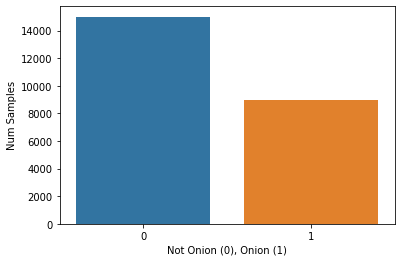

In [5]:
x = data.label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel("Num Samples")
plt.gca().set_xlabel("Not Onion (0), Onion (1)")

# Part 2: Preparing Data

## Converting Text

In [6]:
p_data = data.copy()
# to lower case
p_data["text"] = p_data['text'].str.lower()

# remove ', so you're becomes youre
p_data["text"] = p_data["text"].str.replace(r'[’]', '')
# remove punctuation
p_data["text"] = p_data["text"].str.replace('[^a-zA-Z]', ' ')

# better accuracy then
# p_data['text'] = p_data['text'].str.replace(r'&amp;', 'and')
# p_data['text'] = p_data['text'].str.replace(r'-', ' ')
# p_data['text'] = p_data['text'].str.replace(r'[^\s\w]','')

# comparison test
display(data['text'][2])
display(p_data['text'][2])

'Bold Move: Hulu Has Announced That They’re Gonna Go Ahead And Reboot ‘Shrill’ While It’s Still On Since You Idiots Will Watch Anything'

'bold move  hulu has announced that theyre gonna go ahead and reboot  shrill while its still on since you idiots will watch anything'

## All words in training data

In [7]:
vocab_set = set()
sentence_lengths = []

for i in range(len(p_data)):
    sentence_words = re.split(r'\s',p_data.iloc[i]['text'])
    vocab_set.update(sentence_words)
    sentence_lengths.append(len(sentence_words))

## Tokenization

In [8]:
num_words = len(vocab_set)+1
max_len = 150

frame = p_data["text"]

frame

0        entire facebook staff laughs as man tightens p...
1        muslim woman denied soda can for fear she coul...
2        bold move  hulu has announced that theyre gonn...
3        despondent jeff bezos realizes hell have to wo...
4        for men looking for great single women  online...
                               ...                        
23995    teen pregnancy rate prompting more high school...
23996    connecticut tv station under fire after using ...
23997     jurisprudence fetishist gets off on technicality
23998    employees from other department announce plan ...
23999          police drone crashes into police swat team 
Name: text, Length: 24000, dtype: object

In [9]:
token = Tokenizer(num_words = num_words)
token.fit_on_texts(list(frame))

In [10]:
tokenized = token.texts_to_sequences(frame)

## Comparison

In [11]:
display(data['text'][2])
display(p_data['text'][2])
display(tokenized[2])

'Bold Move: Hulu Has Announced That They’re Gonna Go Ahead And Reboot ‘Shrill’ While It’s Still On Since You Idiots Will Watch Anything'

'bold move  hulu has announced that theyre gonna go ahead and reboot  shrill while its still on since you idiots will watch anything'

[2429,
 976,
 6389,
 31,
 513,
 19,
 603,
 3462,
 140,
 1424,
 11,
 4262,
 14274,
 106,
 61,
 127,
 7,
 632,
 29,
 4263,
 52,
 311,
 668]

## Prepare for model

In [12]:
lstmX = sequence.pad_sequences(tokenized, maxlen = max_len)
dummies = pd.get_dummies(p_data['label'])
lstmY = dummies.values

# Part 3: LSTM Model

In [13]:
x_train, x_test, y_train, y_test = train_test_split(lstmX, lstmY, test_size = 0.1, random_state = 42)

In [14]:
def model():
    emb_size = 128
    
    inp = Input(shape = (max_len, ))
    layer = Embedding(num_words, emb_size)(inp)
    layer = Bidirectional(LSTM(64, return_sequences = True))(layer)
    
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Dense(64, activation = 'relu')(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Dense(2, activation = 'softmax')(layer)
    model = Model(inputs = inp, outputs = layer)
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'nadam', metrics=['accuracy'])
    return model

In [15]:
modl = model()
modl.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 128)          3105664   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 128)          98816     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0   

In [16]:
history = modl.fit(x_train, y_train, batch_size = 32, epochs = 3, validation_split = 0.2)

C:\Users\dakot\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 17280 samples, validate on 4320 samples
Epoch 1/3
17280/17280 [==============================] - 180s 10ms/step - loss: 0.4372 - accuracy: 0.7963 - val_loss: 0.3458 - val_accuracy: 0.8475
Epoch 2/3
17280/17280 [==============================] - 188s 11ms/step - loss: 0.1828 - accuracy: 0.9315 - val_loss: 0.3984 - val_accuracy: 0.8488
Epoch 3/3
17280/17280 [==============================] - 185s 11ms/step - loss: 0.0772 - accuracy: 0.9730 - val_loss: 0.5751 - val_accuracy: 0.8373


# Part 4: Results

In [17]:
val_loss = history.history['val_loss']
print('validation loss: ', val_loss[-1])

training_loss = history.history['loss']
print('training loss: ', training_loss[-1])

validation loss:  0.5751299690317224
training loss:  0.07720565727989499


In [18]:
score = modl.evaluate(x_test, y_test)
print(modl.metrics_names)
print(score)
print('test loss: ', score[0])
print('test accuracy: ', score[1])

2400/2400 [==============================] - 4s 2ms/step
['loss', 'accuracy']
[0.4882003184159597, 0.8500000238418579]
test loss:  0.4882003184159597
test accuracy:  0.8500000238418579


Slightly smaller accuracy then https://www.kaggle.com/salmanhiro/onn-onion-neural-network-with-lstm-85-accuracy, smaller loss. However, commenting out "p_data["text"] = p_data["text"].str.replace(r'[’]', '')" will make it so the accuracies are the same (loss will be still be smaller). I contend that leaving that line makes more sense as a word like they're should be tokenized as theyre not as two tokens of they and re which would match with re in you're.

In [19]:
history.history

{'val_loss': [0.34581765951933685, 0.39840785104919363, 0.5751299690317224],
 'val_accuracy': [0.8474537134170532, 0.8488426208496094, 0.8372685313224792],
 'loss': [0.43716909590142744, 0.18277856862965833, 0.07720565727989499],
 'accuracy': [0.7962963, 0.9314815, 0.97297454]}